#XGBoost Autoregressor

Here we apply XGBoost regressor model to out data. The result - we get some significan, but not dramatic improvement over the ARIMA model baseline. The original data alredy demonstrates very strong seasonal pattern, and our precious SARIMAX model was able to give some reasonable out of sample forecasing predictions. XGBoost further imroves slightly on this baseline, resulting in 0.0527 RMSE score on hold-out data, with visually slightly "tighter" fit. We show that including weather features improves accuracy a bit

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

#Feature engineering
Below is the list of functions we'll be using for generating features to feed into XGBoost model. The features I use here ar very basic and common. Along with the feature generating fuvtions, there are a couple of dataset loaders.

1) get_energy ==> returns the proccessed energy dataframe

2) get_weather ==> returns the processed weather dataframe

3) get_weekly_features ==> adds one-hot encoding of weekday

4) get_time_features ==> endoced time of a day with a sine function

5) get_lag_features ==> adds lagged columns

6) get_rolling_features ==> adds rolling mean and std statistics

7) get_diff_features ==> adds first difference features

8) norm_columns ==> subtracts the mean and devides by std

In [ ]:
def get_energy(file_name="deNaNed_energy.csv", meters=[1], start = np.datetime64("2022-09-01"), end = np.datetime64("2022-09-14")):
    '''reurns a dataframe with meters as columns, with time period croped
    between _start_ and _end_ stamps. The file
    is assumed to be the preprocessed energy consumption data
    with NaN values resolved'''

    #get columns names to extract
    columns = [f"Energy_Meter_{x}" for x in meters]

    #get the dataframe, set the time as index and fix it's type
    df = pd.read_csv(file_name)
    df["Time"] = pd.to_datetime(df["Time"])
    df = df.set_index("Time")

    #extract the needed columns only
    df = df[columns]

    date_start = start
    date_end = end


    if date_start and date_end: #if time stamps are set then crop the df
        time_mask = (df.index <= date_end) & (df.index >= date_start)
        df_short = df[time_mask]
    else: # otherwise just keep the full time period
        df_short = df

    return df_short

def get_weather(file_name="weather_aveiro_final.csv"):
    '''return weather dataframe, drops correlated columns, interpolated missing values'''
    weather_file_name = file_name

    weather_df = pd.read_csv(weather_file_name).set_index("Time")

    #we discovered before that those columns are highly correlated with thier Avg_name analogs, so drop them
    weather_df = weather_df.drop(columns=["Inst_Temp", "Max_Inst_Wind_Speed"])
    weather_df.index = pd.to_datetime(weather_df.index)
    #we also learnt that there a very few sparsly distributed NaN values, so interpolation works just fine here
    weather_df = weather_df.interpolate()

    return weather_df

def get_weekly_features(df):
    '''reurns df augmented with one-hot encoded day of the week features'''
    df_copy = df.copy()

    onehot = pd.get_dummies((df_copy.index.dayofweek))*1 #returns dataframe where columns are unique weekday values,
                                                         #filled with True-False for if the row is in this day

    #rename columns from 0.1,2,3,.. to something readable
    onehot = onehot.rename(columns={i:f"weekday_{i}" for i in range(7)})

    #set the proper time indexing. required for on_index merging
    onehot.index = df_copy.index

    return df_copy.merge(onehot, on="Time") # return the augmented dataframe

def get_time_features(df):
    '''augments given dataframe with numeric time of a day encoding.
        Time is encoded with a sine function with period = one day span'''
    df_copy = df.copy()

    #get indecies isted of time, scale by day duration 96, multiply be 2pi before feeding into sin function
    time_sin = np.sin(df_copy.reset_index().index.to_series()/96*2*np.pi)

    #set index to time for merging
    time_sin.index = df_copy.index

    df_copy["time_encode"] = time_sin

    return df_copy

def get_lag_features(df, columns, lag_min, lag_max, step=1):
    '''returns dataframe augmented with lagged columns as features'''
    df_copy = df.copy()

    for name in columns:
        for lag in range(lag_min, lag_max+1, step):
            df_copy[f"{name}_lag_{lag}"] = df_copy[name].shift(lag)

    return df_copy

def get_rolling_features(df, columns, window):
    '''retuens dataframe augmnted with rolling statistics (mean, std) of columns
        where the window size is _window_ argument'''
    df_copy = df.copy()

    for name in columns:
        df_copy[f"{name}_mean"] = df_copy[name].rolling(window).mean().shift(1)
        df_copy[f"{name}_std"] = df_copy[name].rolling(window).std().shift(1)

    return df_copy.dropna()

def get_diff_features(df, columns):
    '''returns dataframe augmnted with first differences of columns'''
    df_copy = df.copy()

    for name in columns:
        df_copy[f"{name}_diff"] = df_copy[name].diff()

    return df_copy.dropna()

def get_normed(df, columns):
    '''sets mean and variance of each column to 0 and 1 respectively.
      returns the normalized dataframe'''
    df_copy = df.copy()
    df_copy[columns] = (df_copy[columns] - df_copy[columns].mean()) / df_copy[columns].std()

    return df_copy


#XGBoost on features without weather

First let's see how the model will perform in autoregressive regime first. We will use lagged features from 1 to 96 lags, day of a week one-hot features and time of day features to stimulate seasonal patterns. We also include rolling statistics to account for non-stationarity of the data. We also use diff features for stationalry input.

For now we train on only one data sequence, with time series cross validation. Training on many sequences requires much more care as different energy consumption plots can have dramatically different shapes as we saw during our clusterization step - dataset turned out to be highly inhomogenous.

In [ ]:
n = 1
TARGET = f"Energy_Meter_{n}"

df = get_energy(meters = [n], start=None, end=None)

def create_featuers(data, target, norm=True):
    df = data.copy()
    df = get_weekly_features(df)
    df = get_time_features(df)
    df = get_diff_features(df, [target])
    df = get_lag_features(df, [target, f"{target}_diff"], 1, 96).drop(columns=[f"{target}_diff"])
    df = get_rolling_features(df, [target], 96)

    if norm:
        dont_norm = [f"weekday_{i}" for i in range(7)]
        norm_columns = [x for x in df.columns if not (x in dont_norm)]

        df = get_normed(df, norm_columns)

    return df

df = create_featuers(df, TARGET)

/tmp/ipython-input-3770389149.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f"{name}_lag_{lag}"] = df_copy[name].shift(lag)
/tmp/ipython-input-3770389149.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f"{name}_lag_{lag}"] = df_copy[name].shift(lag)
/tmp/ipython-input-3770389149.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

In [ ]:
list(df.columns)

['Energy_Meter_1',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'time_encode',
 'Energy_Meter_1_lag_1',
 'Energy_Meter_1_lag_2',
 'Energy_Meter_1_lag_3',
 'Energy_Meter_1_lag_4',
 'Energy_Meter_1_lag_5',
 'Energy_Meter_1_lag_6',
 'Energy_Meter_1_lag_7',
 'Energy_Meter_1_lag_8',
 'Energy_Meter_1_lag_9',
 'Energy_Meter_1_lag_10',
 'Energy_Meter_1_lag_11',
 'Energy_Meter_1_lag_12',
 'Energy_Meter_1_lag_13',
 'Energy_Meter_1_lag_14',
 'Energy_Meter_1_lag_15',
 'Energy_Meter_1_lag_16',
 'Energy_Meter_1_lag_17',
 'Energy_Meter_1_lag_18',
 'Energy_Meter_1_lag_19',
 'Energy_Meter_1_lag_20',
 'Energy_Meter_1_lag_21',
 'Energy_Meter_1_lag_22',
 'Energy_Meter_1_lag_23',
 'Energy_Meter_1_lag_24',
 'Energy_Meter_1_lag_25',
 'Energy_Meter_1_lag_26',
 'Energy_Meter_1_lag_27',
 'Energy_Meter_1_lag_28',
 'Energy_Meter_1_lag_29',
 'Energy_Meter_1_lag_30',
 'Energy_Meter_1_lag_31',
 'Energy_Meter_1_lag_32',
 'Energy_Meter_1_lag_33',
 'Energy_Meter_1_l

In [ ]:
TARGET = "Energy_Meter_1"
FEATURES = [x for x in df.columns if not x == TARGET]

###Cross-Validation
We start our analysis with simple time series cross-validation. It will hint us at if the data distribution shift as time progresses. If te distribution is stable and the model is able to extract more structure from the growing number of datapoints, we'll see the loss going down overall as we make teh training set bigger. We plot the training sets used for cross validation below:

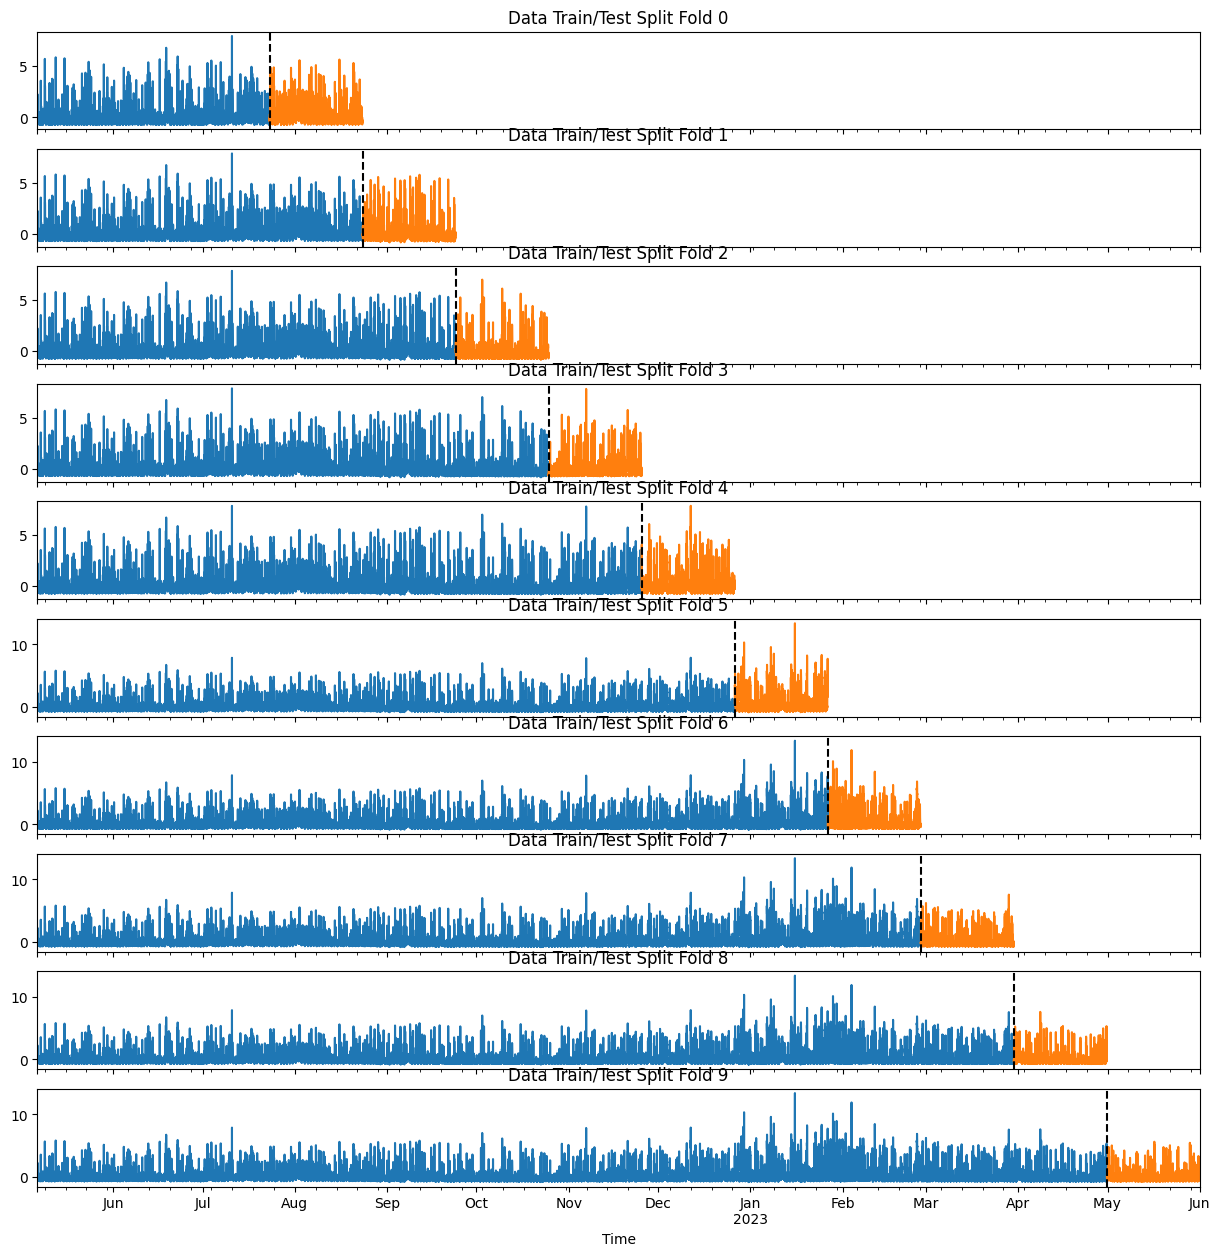

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10, test_size=3000, gap=0)

fig, axs = plt.subplots(10, 1, figsize=(15, 30), sharex=True)

fold = 0
data = df[TARGET]

for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]
    train.plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test.plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Here we introduce some auxiliary vars and defs that we'll use repeatedly:

In [ ]:
#we'll use this parameters for XGBoost regressor throught the code
standard_settings = {
                      "base_score":0.5,
                      "booster" : 'gbtree',
                      "n_estimators" : 5000,
                      "early_stopping_rounds" : 50,
                      "objective" : 'reg:squarederror',
                      "max_depth" : 3,
                      "learning_rate" : 0.01
                    }

def train_model(reg, train, test, target, features):
    '''reg : initialized XGBoost model

       train : train half of the dataset, includes both targets and features

       test : test half of the dataset, includes both targets and features

       target : name of the target column

       features : list of feature columns names

       fits the regressor, returns (predictions, RMSE)'''

    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))

    return (y_pred, score)

Run through all of the splits and fit a regressor to each. We'll take 10 splits total with 3k test set length:

In [ ]:
data = df
tss = TimeSeriesSplit(n_splits=10, test_size=3000, gap=0)

preds = [] #list of validation set predictions
scores = [] #list of RMSE scores

for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]

    reg = xgb.XGBRegressor(**standard_settings)

    results = train_model(reg, train, test, TARGET, FEATURES)
    preds.append(results[0])
    scores.append(results[1])

[0]	validation_0-rmse:0.86793
[100]	validation_0-rmse:0.62505
[200]	validation_0-rmse:0.58425
[300]	validation_0-rmse:0.57591
[400]	validation_0-rmse:0.57469
[459]	validation_0-rmse:0.57468
[0]	validation_0-rmse:0.98548
[100]	validation_0-rmse:0.67320
[200]	validation_0-rmse:0.61417
[300]	validation_0-rmse:0.60157
[400]	validation_0-rmse:0.59972
[482]	validation_0-rmse:0.60010
[0]	validation_0-rmse:0.99408
[100]	validation_0-rmse:0.61388
[200]	validation_0-rmse:0.52808
[300]	validation_0-rmse:0.50657
[400]	validation_0-rmse:0.50100
[500]	validation_0-rmse:0.49822
[600]	validation_0-rmse:0.49782
[697]	validation_0-rmse:0.49771
[0]	validation_0-rmse:0.99129
[100]	validation_0-rmse:0.63491
[200]	validation_0-rmse:0.56310
[300]	validation_0-rmse:0.54774
[400]	validation_0-rmse:0.54299
[500]	validation_0-rmse:0.54195
[600]	validation_0-rmse:0.54179
[631]	validation_0-rmse:0.54180
[0]	validation_0-rmse:0.96159
[100]	validation_0-rmse:0.67858
[200]	validation_0-rmse:0.62798
[300]	validation_0

We plot the resulting losses below:

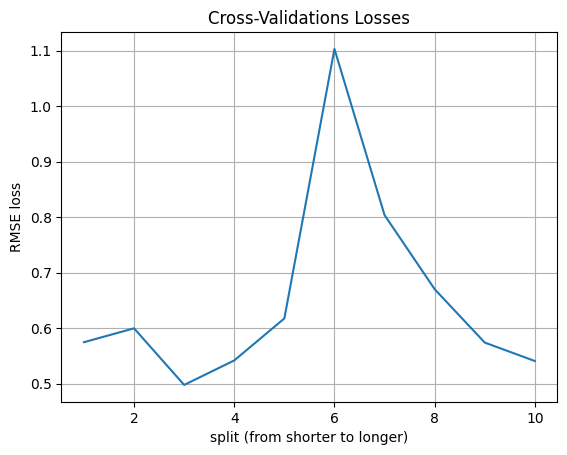

In [ ]:
plt.plot(np.array(range(10))+1, scores)
plt.xlabel("split (from shorter to longer)")
plt.ylabel("RMSE loss")
plt.title("Cross-Validations Losses")
plt.grid()

On the plot above we see that the loss suddenly grows at 6th fold, and then slowly recoverse at later flolds. On the splits visualization plot before we see that thr 6th fold is exectly when an unusually high value enters the training set, causing the model to overfit to it due to the high loss score.

###Backwards cross-validation

Now we fix the validation set and only extend the training set in length to the left of teh validation set. This way it gives more clear comparison, as we test all the splits fits on the same validation set. We can see how the length of the training set affects the performance on future time steps, how consistent is our dataset.

In [ ]:
date_start = np.datetime64("2023-04-01") # the begining of the original training set
date_end = np.datetime64("2023-06-01") # the end of the original validation set
val_start = date_end - 28 # fist date of val data
interval = 28 # days to skip per extention
n_extentions = 10 # how many extentions to try

new_data = df.copy()

# set the list of extention starts
# the corresponding training periods are [extention_start, val_start)
extention_starts = [date_start-interval*i for i in range(n_extentions)]

# now only keep the data before validation end
new_data = new_data[new_data.index <= date_end]

# define the validation set as before
test_mask = new_data.index >= val_start
test_df = new_data[test_mask]

# define the training set as the longest train extention
last_ext = extention_starts[-1]
train_mask = (new_data.index < val_start) & (new_data.index >= last_ext)
train_df = new_data[train_mask]


We plot our trainimg sets below:

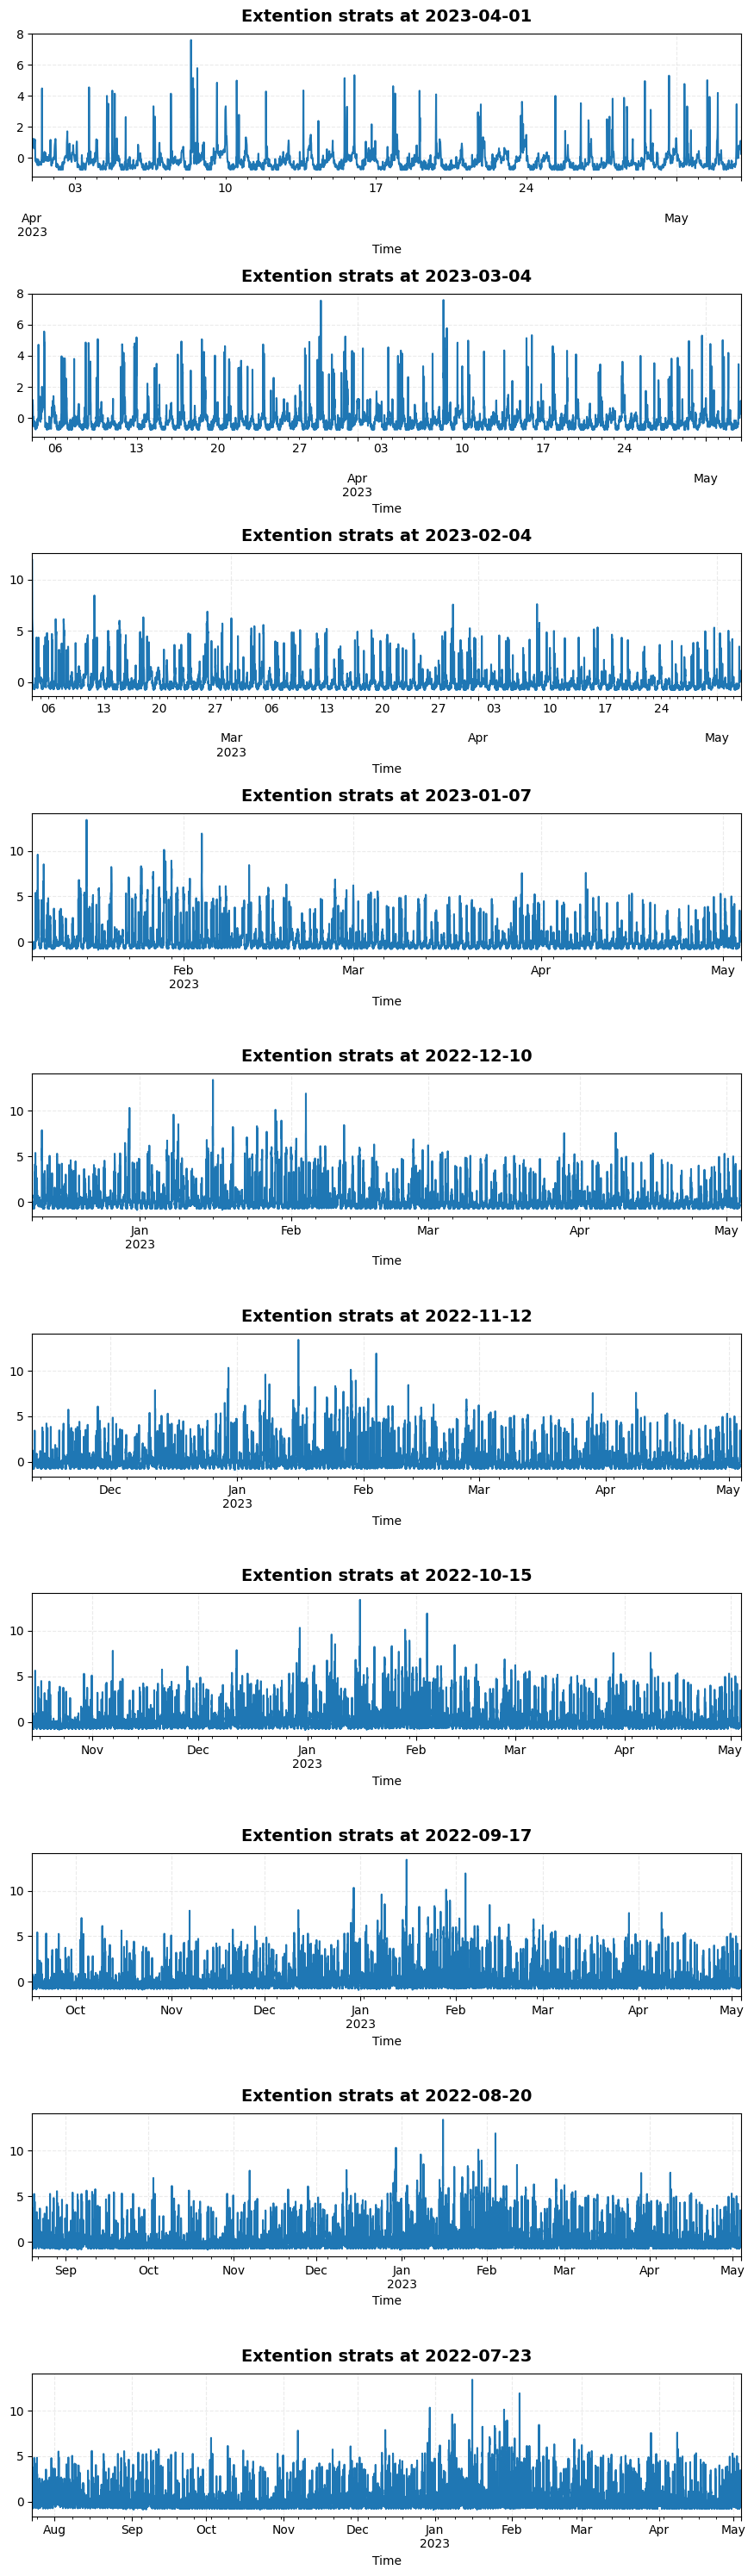

In [ ]:
_,axs = plt.subplots(n_extentions, 1, figsize=(9, 3*n_extentions))

for start, ax in zip(extention_starts, axs):
    train_df[train_df.index >= start][TARGET].plot(ax=ax)
    ax.set_title(f"Extention strats at {start}", fontsize=14, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

Fit regressor to each of the training sets separately

In [ ]:
preds = []
scores = []

for start in tqdm(extention_starts):
    train = train_df[train_df.index >= start]
    test = test_df

    reg = xgb.XGBRegressor(**standard_settings)

    results = train_model(reg, train, test, TARGET, FEATURES)
    preds.append(results[0])
    scores.append(results[1])

  0%|          | 0/10 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.96618
[100]	validation_0-rmse:0.62726
[200]	validation_0-rmse:0.56264
[300]	validation_0-rmse:0.55286
[400]	validation_0-rmse:0.55052
[500]	validation_0-rmse:0.54879
[600]	validation_0-rmse:0.54801
[700]	validation_0-rmse:0.54768
[748]	validation_0-rmse:0.54786


 10%|█         | 1/10 [00:09<01:22,  9.22s/it]

[0]	validation_0-rmse:0.96600
[100]	validation_0-rmse:0.61542
[200]	validation_0-rmse:0.55366
[300]	validation_0-rmse:0.54373
[400]	validation_0-rmse:0.54085
[450]	validation_0-rmse:0.54100


 20%|██        | 2/10 [00:14<00:56,  7.01s/it]

[0]	validation_0-rmse:0.96615
[100]	validation_0-rmse:0.61964
[200]	validation_0-rmse:0.55562
[300]	validation_0-rmse:0.54527
[400]	validation_0-rmse:0.54216
[500]	validation_0-rmse:0.54152
[554]	validation_0-rmse:0.54157


 30%|███       | 3/10 [00:24<00:56,  8.13s/it]

[0]	validation_0-rmse:0.96629
[100]	validation_0-rmse:0.62263
[200]	validation_0-rmse:0.56209
[300]	validation_0-rmse:0.55261
[400]	validation_0-rmse:0.54965
[485]	validation_0-rmse:0.54947


 40%|████      | 4/10 [00:31<00:46,  7.79s/it]

[0]	validation_0-rmse:0.96627
[100]	validation_0-rmse:0.62256
[200]	validation_0-rmse:0.56038
[300]	validation_0-rmse:0.55091
[400]	validation_0-rmse:0.54849
[500]	validation_0-rmse:0.54671
[600]	validation_0-rmse:0.54653
[614]	validation_0-rmse:0.54651


 50%|█████     | 5/10 [00:43<00:47,  9.44s/it]

[0]	validation_0-rmse:0.96606
[100]	validation_0-rmse:0.61986
[200]	validation_0-rmse:0.55616
[300]	validation_0-rmse:0.54591
[400]	validation_0-rmse:0.54366
[500]	validation_0-rmse:0.54260
[600]	validation_0-rmse:0.54246
[605]	validation_0-rmse:0.54247


 60%|██████    | 6/10 [00:56<00:41, 10.48s/it]

[0]	validation_0-rmse:0.96602
[100]	validation_0-rmse:0.61830
[200]	validation_0-rmse:0.55659
[300]	validation_0-rmse:0.54737
[400]	validation_0-rmse:0.54402
[500]	validation_0-rmse:0.54220
[600]	validation_0-rmse:0.54184
[700]	validation_0-rmse:0.54162
[783]	validation_0-rmse:0.54157


 70%|███████   | 7/10 [01:13<00:38, 12.73s/it]

[0]	validation_0-rmse:0.96600
[100]	validation_0-rmse:0.61469
[200]	validation_0-rmse:0.55174
[300]	validation_0-rmse:0.54274
[400]	validation_0-rmse:0.54068
[500]	validation_0-rmse:0.53926
[545]	validation_0-rmse:0.53937


 80%|████████  | 8/10 [01:26<00:25, 12.80s/it]

[0]	validation_0-rmse:0.96610
[100]	validation_0-rmse:0.61561
[200]	validation_0-rmse:0.55451
[300]	validation_0-rmse:0.54457
[400]	validation_0-rmse:0.54244
[500]	validation_0-rmse:0.54054
[600]	validation_0-rmse:0.53939
[700]	validation_0-rmse:0.53897
[800]	validation_0-rmse:0.53885
[900]	validation_0-rmse:0.53855
[1000]	validation_0-rmse:0.53817
[1100]	validation_0-rmse:0.53794
[1200]	validation_0-rmse:0.53774
[1300]	validation_0-rmse:0.53752
[1400]	validation_0-rmse:0.53715
[1500]	validation_0-rmse:0.53687
[1600]	validation_0-rmse:0.53659
[1700]	validation_0-rmse:0.53637
[1800]	validation_0-rmse:0.53625
[1900]	validation_0-rmse:0.53624
[1916]	validation_0-rmse:0.53622


 90%|█████████ | 9/10 [02:07<00:21, 21.67s/it]

[0]	validation_0-rmse:0.96618
[100]	validation_0-rmse:0.61717
[200]	validation_0-rmse:0.55401
[300]	validation_0-rmse:0.54248
[400]	validation_0-rmse:0.53938
[500]	validation_0-rmse:0.53781
[600]	validation_0-rmse:0.53731
[700]	validation_0-rmse:0.53677
[800]	validation_0-rmse:0.53649
[900]	validation_0-rmse:0.53624
[1000]	validation_0-rmse:0.53595
[1100]	validation_0-rmse:0.53570
[1200]	validation_0-rmse:0.53574
[1210]	validation_0-rmse:0.53575


100%|██████████| 10/10 [02:35<00:00, 15.55s/it]


We plot the resulting RMSE scores below - the training set length gets bigger from left to righ:

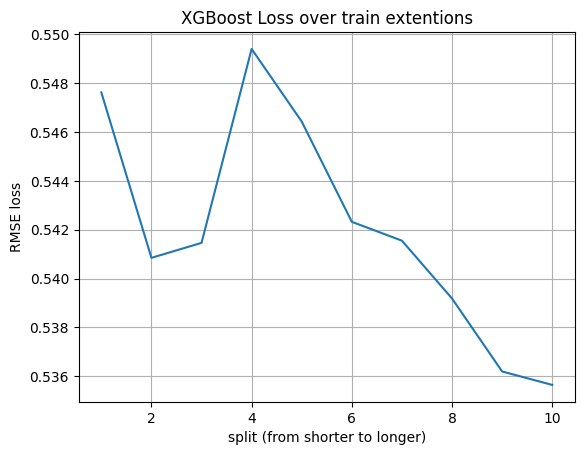

In [ ]:
plt.plot(np.array(range(10))+1, scores)
plt.xlabel("split (from shorter to longer)")
plt.ylabel("RMSE loss")
plt.title("XGBoost Loss over train extentions")
plt.grid()

We see the loss is steadily going down as the thraining set length gets bigger. We also see a sudden increase in loss at the 4th fold - this is where the sudden spike the data enters the training set, which confuses the model.

For now let's see the models predictions and residuals on the vadidation set:

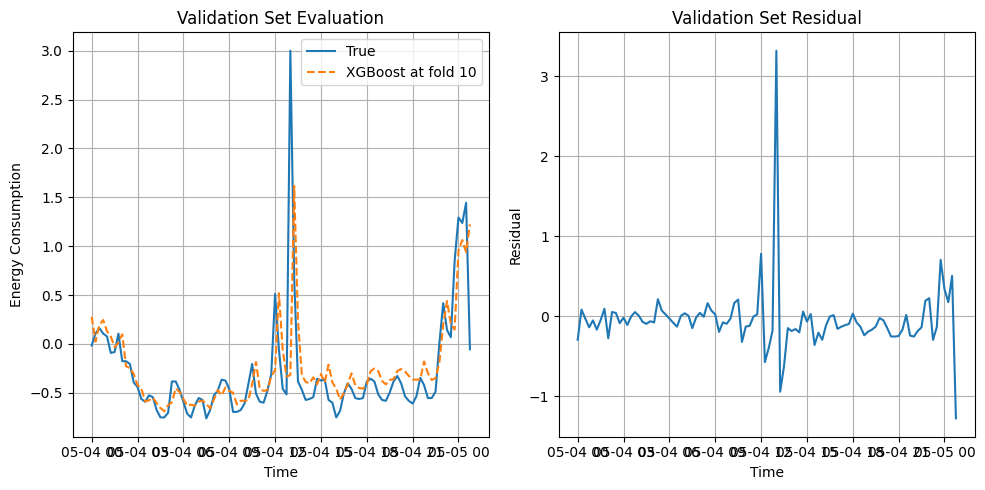

In [ ]:
k = 9
data = test_df
cut = 100

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(data.index[:cut], data[TARGET][:cut], label=f"True")
ax1.plot(data.index[:cut], preds[k][:cut], label=f"XGBoost at fold {k+1}", ls="--")
ax1.set_xlabel("Time")
ax1.set_ylabel("Energy Consumption")
ax1.grid(True)
ax1.set_title("Validation Set Evaluation")
ax1.legend()

ax2.plot(data.index[:cut], data[TARGET][:cut]- preds[k][:cut])
ax2.set_xlabel("Time")
ax2.set_ylabel("Residual")
ax2.grid(True)
ax2.set_title("Validation Set Residual")

plt.tight_layout()
plt.show()

The residuals seem very similar to that of ARIMA model below. though the predictions plot looks like it gives a "tighter" fit


We should compare the result to our ARIMA model baseline as well:

###ARIMA model baseline

We set the parameters of the ARIMA model as in our ARIMA model analysis before. MA variation gave a good performance on the in-sample test, so we continue with it, first cross-validating it over different extentions for a fair comparison

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (0, 1, 24) # AR(p), diff(d), MA(q)

train_loss = []
val_loss = []
sarima_preds = []

for start in tqdm(extention_starts):
    order = (0, 1, 12) # AR(p), diff(d), MA(q)
    seasonal_order = (0, 0, 0, 0) # SAR(p), diff(d), SMA(q), seasonal_diff(s)

    model = SARIMAX(endog = train_df[train_df.index >= start][TARGET], order=order, seasonal_order=seasonal_order, method='innovations_mle')
    results = model.fit()

    #grtting the train loss, very straighforward
    train_mse = np.sqrt(mean_squared_error(results.fittedvalues, train_df[train_df.index >= start][TARGET]))

    #getting validation loss, predict on test sets values only
    #first we extend the dataset, then use model.predict to get the predictions
    res = results.append(test_df[TARGET], refit=False)
    y_pred = res.predict(start=len(train_df[train_df.index >= start]), end=len(train_df[train_df.index >= start])+len(test_df)-1)
    y_pred.index = test_df.index
    sarima_preds.append(y_pred)

    #now simply eval the losses, just as before
    test_mse = np.sqrt(mean_squared_error(test_df[TARGET], y_pred))

    train_loss.append(train_mse)
    val_loss.append(test_mse)


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 1

In [ ]:
print(f"The best score is {np.min(scores)}")

The best score is 0.5356475963180233


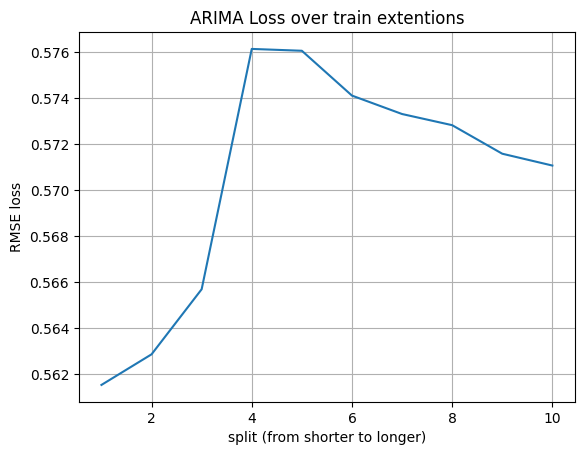

In [ ]:
plt.plot(np.array(range(len(val_loss)))+1, val_loss)
plt.xlabel("split (from shorter to longer)")
plt.ylabel("RMSE loss")
plt.title("ARIMA Loss over train extentions")
plt.grid()

We see that ARIMA model experiences the same shok at 4th fold, but in this case it never really recovers from it

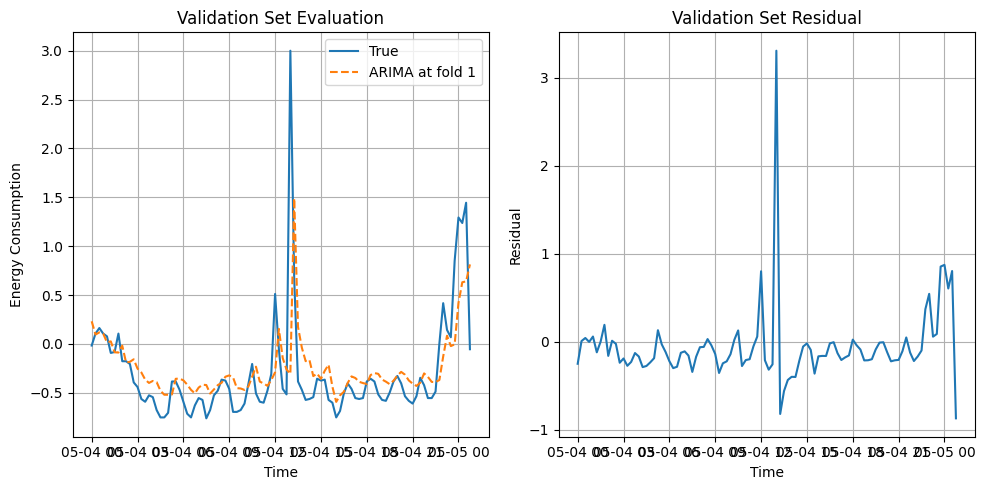

In [ ]:
k = 0
data = test_df
cut = 100

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(data.index[:cut], data[TARGET][:cut], label=f"True")
ax1.plot(data.index[:cut], sarima_preds[k][:cut], label=f"ARIMA at fold {k+1}", ls="--")
ax1.set_xlabel("Time")
ax1.set_ylabel("Energy Consumption")
ax1.grid(True)
ax1.set_title("Validation Set Evaluation")
ax1.legend()

ax2.plot(data.index[:cut], data[TARGET][:cut]- sarima_preds[k][:cut])
ax2.set_xlabel("Time")
ax2.set_ylabel("Residual")
ax2.grid(True)
ax2.set_title("Validation Set Residual")

plt.tight_layout()
plt.show()

The loss achieved by the ARIMA model is higher, and the visually apparent fitness is worse

#XGBoost with weather features

Now we do the same thing as before with the only diffrence being that we include lagged weather features. The lags are from 1 to 96 measurements into the past. Though this choice is suboptimal for practical applications where we want to forcast into the future using currently available data only, this sets us a good baseline performance

In [ ]:
n = 1

df = get_energy(meters = [n], start=None, end=None)

weather_columns = ["Avg_Temp", "Total_Global_Rad", "Avg_Rel_Humidity"]
weather_df = get_weather()[weather_columns]
weather_df = weather_df.reindex(index=df.index)

#get joint weather&energy dataframe
df = df.merge(weather_df, on="Time")

df = get_weekly_features(df)
df = get_time_features(df)
# df = get_diff_features(df, [f"Energy_Meter_{n}"])
df = get_lag_features(df, [f"Energy_Meter_{n}"], 1, 97, 8)
df = get_rolling_features(df, [f"Energy_Meter_{n}"], 96)

#also add weather rolling stats
df = get_rolling_features(df, weather_columns, 96)

#get weather features to lag
lag_weather = weather_columns

#take lagged weather features only
df = get_lag_features(df, lag_weather, 1, 97, 8).drop(columns=lag_weather)

#exclude dont_norm features from normalization step, it includes weekday encoding
dont_norm = [f"weekday_{i}" for i in range(7)]
norm_columns = [x for x in df.columns if not (x in dont_norm)]

df = get_normed(df, norm_columns)

Let's list all teh columns to make sure there is no error (like forgetting to exclude current time weather features):

In [ ]:
list(df.columns)

['Energy_Meter_1',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'time_encode',
 'Energy_Meter_1_lag_1',
 'Energy_Meter_1_lag_9',
 'Energy_Meter_1_lag_17',
 'Energy_Meter_1_lag_25',
 'Energy_Meter_1_lag_33',
 'Energy_Meter_1_lag_41',
 'Energy_Meter_1_lag_49',
 'Energy_Meter_1_lag_57',
 'Energy_Meter_1_lag_65',
 'Energy_Meter_1_lag_73',
 'Energy_Meter_1_lag_81',
 'Energy_Meter_1_lag_89',
 'Energy_Meter_1_lag_97',
 'Energy_Meter_1_mean',
 'Energy_Meter_1_std',
 'Avg_Temp_mean',
 'Avg_Temp_std',
 'Total_Global_Rad_mean',
 'Total_Global_Rad_std',
 'Avg_Rel_Humidity_mean',
 'Avg_Rel_Humidity_std',
 'Avg_Temp_lag_1',
 'Avg_Temp_lag_9',
 'Avg_Temp_lag_17',
 'Avg_Temp_lag_25',
 'Avg_Temp_lag_33',
 'Avg_Temp_lag_41',
 'Avg_Temp_lag_49',
 'Avg_Temp_lag_57',
 'Avg_Temp_lag_65',
 'Avg_Temp_lag_73',
 'Avg_Temp_lag_81',
 'Avg_Temp_lag_89',
 'Avg_Temp_lag_97',
 'Total_Global_Rad_lag_1',
 'Total_Global_Rad_lag_9',
 'Total_Global_Rad_lag_17',
 'Total

In [ ]:
date_end = np.datetime64("2023-06-01") # the end of the original validation set
val_start = date_end - 28 # fist date of val data

new_data = df.copy()

# now only keep the data before validation end
new_data = new_data[new_data.index <= date_end]

# define the validation set as before
test_mask = new_data.index >= val_start
test_df = new_data[test_mask]

# define the training set
train_mask = new_data.index < val_start
train_df = new_data[train_mask]


In [ ]:
TARGET = f"Energy_Meter_{n}"
FEATURES = [x for x in df.columns if not x == TARGET]

In [ ]:
reg = xgb.XGBRegressor(**standard_settings)

pred, score = train_model(reg, train_df, test_df, TARGET, FEATURES)

[0]	validation_0-rmse:0.96590
[100]	validation_0-rmse:0.61585
[200]	validation_0-rmse:0.54854
[300]	validation_0-rmse:0.53573
[400]	validation_0-rmse:0.53234
[500]	validation_0-rmse:0.53034
[600]	validation_0-rmse:0.52950
[700]	validation_0-rmse:0.52889
[800]	validation_0-rmse:0.52830
[900]	validation_0-rmse:0.52785
[1000]	validation_0-rmse:0.52757
[1038]	validation_0-rmse:0.52763


In [ ]:
print(f"The final RMSE score on the validation set is {score}")

The final RMSE score on the validation set is 0.5275652660804974


We see no improvement over the model that doesn't use weather features. It might be due to the fact that we are using lags that are too big, and there is not much usefull information to extract. But we also can't use recent weather data as features as it is not available to us beforehand, so we cant use it fore future forcasting. Using a weather forcasting model as a way to resolve this issue will introduce an additional forcasting error.

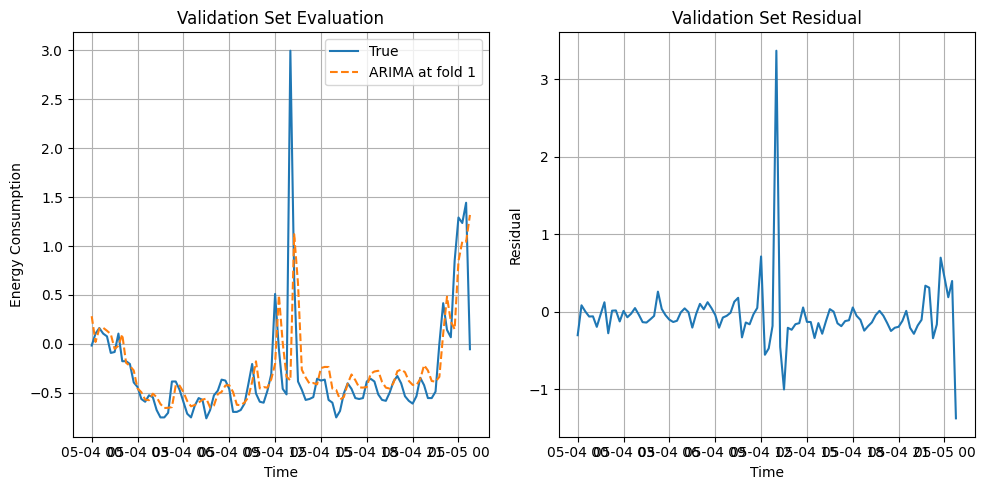

In [ ]:
data = test_df
cut = 100

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(data.index[:cut], data[TARGET][:cut], label=f"True")
ax1.plot(data.index[:cut], pred[:cut], label=f"ARIMA at fold {k+1}", ls="--")
ax1.set_xlabel("Time")
ax1.set_ylabel("Energy Consumption")
ax1.grid(True)
ax1.set_title("Validation Set Evaluation")
ax1.legend()

ax2.plot(data.index[:cut], data[TARGET][:cut]- pred[:cut])
ax2.set_xlabel("Time")
ax2.set_ylabel("Residual")
ax2.grid(True)
ax2.set_title("Validation Set Residual")

plt.tight_layout()
plt.show()

We now should look at the feature importance diagram, from which we see that the model is indeed using weather features as helpful predictors. We also see that the model doesn't use weekly features at all, and give little credit to the time feature

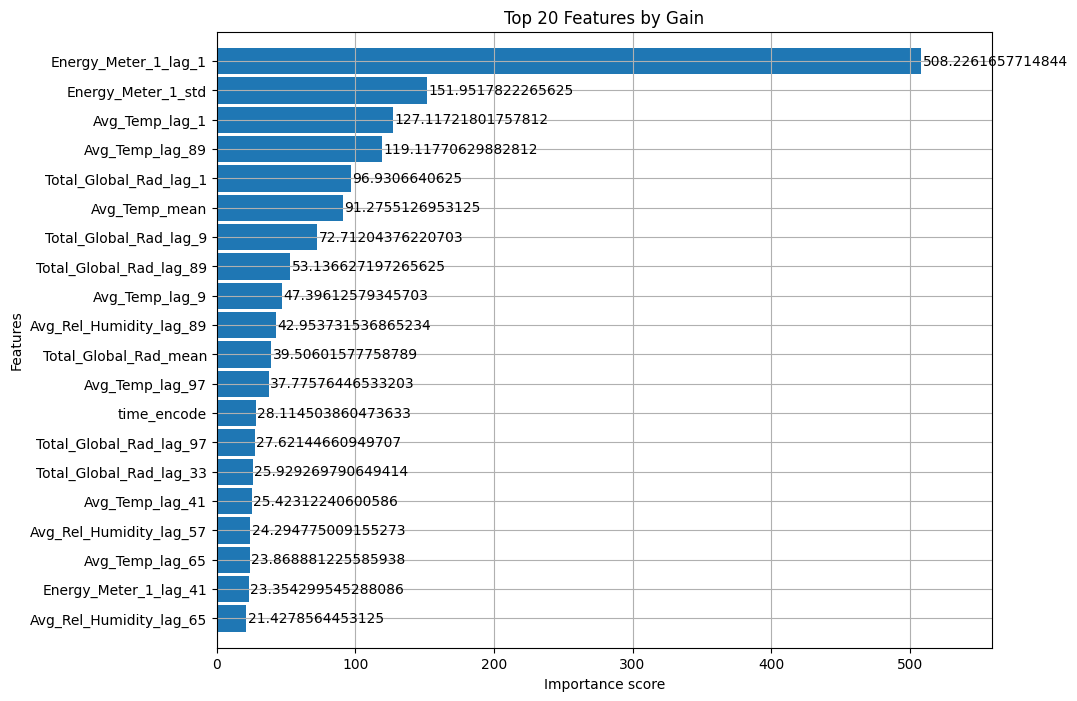

In [ ]:
from xgboost import plot_importance

_, ax = plt.subplots(figsize=(10, 8))
plot_importance(
    reg,
    ax=ax,
    max_num_features=20,  # ← KEY PARAMETER
    height=0.9,
    importance_type='gain',  # 'gain' is more informative than 'weight'
    title='Top 20 Features by Gain'
)
plt.show()